In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from src.data_processor.phase_2.prob2.v1 import  Phase2Prob2FeatureProcessor
import numpy as np

In [2]:
df = pd.read_parquet("D:/Data/MLOPS_2023/data_phase-2/phase-2/prob-2/raw_train.parquet")
df['label'].value_counts()

label
Normal                   22390
Other                    13963
Exploits                 10864
Denial of Service         9585
Information Gathering     4081
Malware                    958
Name: count, dtype: int64

In [3]:
df.drop_duplicates(inplace=True)
df['label'].value_counts()

label
Normal                   21549
Exploits                  8256
Denial of Service         7322
Other                     4808
Information Gathering     3196
Malware                    926
Name: count, dtype: int64

In [4]:
df.reset_index(drop=True, inplace=True)
x = df.groupby(['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6',
                'feature7', 'feature8', 'feature9', 'feature10', 'feature11',
                'feature12', 'feature13', 'feature14', 'feature15', 'feature16',
                'feature17', 'feature18', 'feature19', 'feature20', 'feature21',
                'feature22', 'feature23', 'feature24', 'feature25', 'feature26',
                'feature27', 'feature28', 'feature29', 'feature30', 'feature31',
                'feature32', 'feature33', 'feature34', 'feature35', 'feature36',
                'feature37', 'feature38', 'feature39', 'feature40', 'feature41']).apply(lambda x : list(x.index)).reset_index()
a = x[x[0].apply(lambda x: len(x)>1)]
blacklist = []
for t in a[0].values:
    blacklist.extend(t)
    index = np.array(blacklist)
not_index = np.setdiff1d(df.index.to_numpy(), index)
df = df.iloc[not_index]
df.reset_index(inplace=True, drop=True)
df['label'].value_counts()

label
Normal                   21480
Exploits                  6778
Denial of Service         5811
Other                     4740
Information Gathering     2369
Malware                    494
Name: count, dtype: int64

In [5]:
HyperParameters={'objective': 'multiclass',
                 'n_estimators':100,
                 'learning_rate':0.1,
                 'max_depth':7,
                 'colsample_bytree':0.5,
                 'subsample':0.8,
                 'random_state':42
              }
hyper_parameters = HyperParameters.copy()

In [6]:
processor = Phase2Prob2FeatureProcessor()
new_df = processor.transform(df)

In [7]:
new_df.shape

(41672, 41)

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
FEATURES = processor.data_features['features']
categorical = processor.data_features['categorical_features']
TARGET = 'label'


models = []
scores = []
oofs = np.empty(df.shape[0], dtype='object')
for i, (train_idx, valid_idx) in enumerate(kfold.split(new_df, df['label'])):
    # Xy_train = new_df.iloc[train_idx]
    # Xy_train['label'] = df.iloc[train_idx][TARGET]
    # Xy_train_NORMAL = Xy_train[Xy_train.label.apply(lambda x: x == 'Malware')]
    # Xy_train_NORMAL_sample = Xy_train_NORMAL.sample(frac=1, random_state=42)
    # # print(Xy_train_NORMAL_sample['label'].value_counts())
    # Xy_train_OTHER = Xy_train[Xy_train.label.apply(lambda x: x != 'Malware')]
    # Xy_train_sample = pd.concat([Xy_train_OTHER,Xy_train_NORMAL_sample])
    # Xy_train_sample = Xy_train_sample.sample(frac=1,random_state=123)
    # print(Xy_train_sample['label'].value_counts())

    X_train = new_df.iloc[train_idx]
    y_train = df.iloc[train_idx][TARGET]
    X_valid = new_df.iloc[valid_idx]
    y_valid = df.iloc[valid_idx][TARGET]


    print(X_train.shape, X_valid.shape)
    print(y_train.shape, y_valid.shape)
    model = LGBMClassifier(**hyper_parameters)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              eval_metric=["logloss"],
              categorical_feature=categorical,
              early_stopping_rounds=50,
              verbose=50)
    # model = CatBoostClassifier(iterations=100, learning_rate=0.05, max_depth=7, subsample=0.8, random_state=42,eval_metric='AUC',class_weights={1:1.5,0:1})
    # model.fit(X_train, y_train,
    #           cat_features=categorical,
    #           eval_set=[(X_train, y_train), (X_valid, y_valid)])
    models.append(model)
    y_pred = model.predict(X_valid)
    oofs[valid_idx] = y_pred

    print(f"fold {i} : {accuracy_score(y_valid, y_pred)}")
    print(classification_report(y_valid, y_pred))
    scores.append(accuracy_score(y_valid, y_pred))

print(np.mean(scores), np.std(scores))
print(classification_report(df[TARGET], oofs))
print(accuracy_score(df[TARGET], oofs))

(33337, 41) (8335, 41)
(33337,) (8335,)
[50]	training's multi_logloss: 0.256182	valid_1's multi_logloss: 0.309589
[100]	training's multi_logloss: 0.201656	valid_1's multi_logloss: 0.29914
fold 0 : 0.871505698860228
                       precision    recall  f1-score   support

    Denial of Service       0.70      0.54      0.61      1163
             Exploits       0.83      0.89      0.86      1356
Information Gathering       0.88      0.85      0.86       473
              Malware       0.76      0.58      0.66        99
               Normal       0.90      0.95      0.92      4296
                Other       0.99      0.96      0.97       948

             accuracy                           0.87      8335
            macro avg       0.84      0.79      0.81      8335
         weighted avg       0.87      0.87      0.87      8335

(33337, 41) (8335, 41)
(33337,) (8335,)
[50]	training's multi_logloss: 0.252961	valid_1's multi_logloss: 0.318842
[100]	training's multi_logloss: 0.1969

In [10]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(df[TARGET],oofs,labels=models[0].classes_), display_labels=models[0].classes_)

In [11]:
confusion_matrix(df[TARGET],oofs,labels=models[0].classes_)

array([[ 3166,   678,    21,    52,  1877,    17],
       [  269,  6058,   163,    54,   209,    25],
       [   25,   251,  1968,     5,   120,     0],
       [   75,    91,     7,   276,    41,     4],
       [ 1009,   156,    20,    12, 20278,     5],
       [   57,   133,     0,     6,    14,  4530]], dtype=int64)

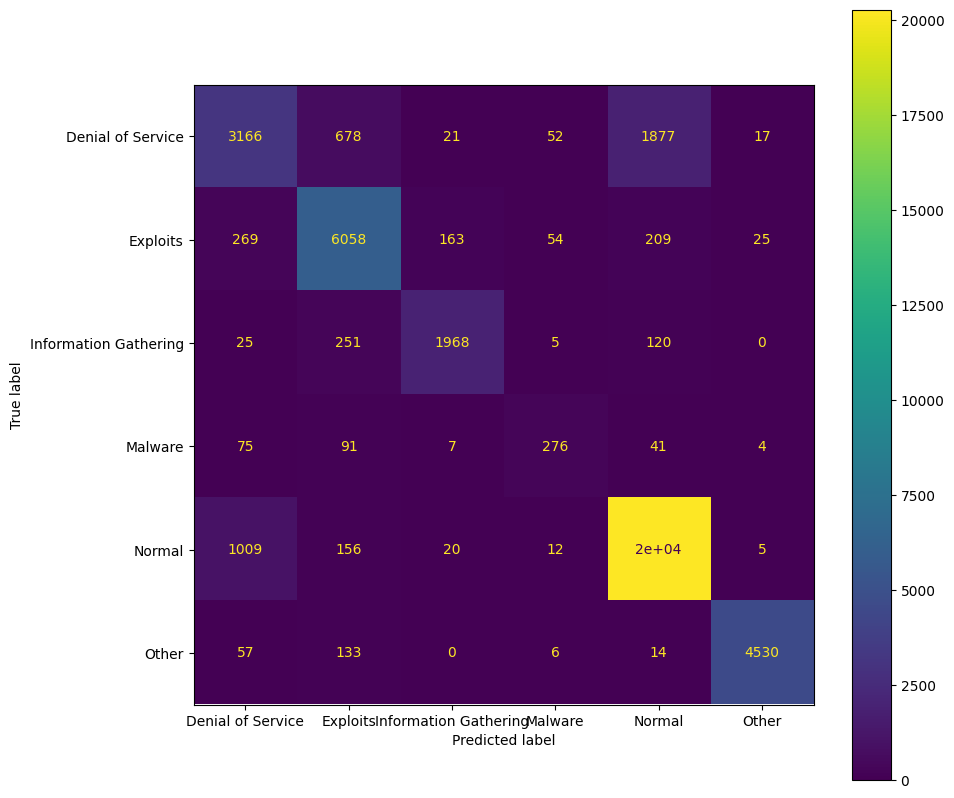

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10,10))
disp.plot(ax=ax)

In [13]:
gmodel = LGBMClassifier(**models[0].get_params())
gmodel.fit(new_df[FEATURES], df[TARGET],
           eval_set=[(new_df[FEATURES],df[TARGET])],
           eval_metric=["logloss"],
           categorical_feature=categorical,
           verbose=50)

with open(f'../checkpoints/phase-2/prob-2/v1.pkl','wb') as file:
    pickle.dump(gmodel, file)

[50]	valid_0's multi_logloss: 0.260995
[100]	valid_0's multi_logloss: 0.210903


In [17]:
x = df.groupby(['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6',
            'feature7', 'feature8', 'feature9', 'feature10', 'feature11',
            'feature12', 'feature13', 'feature14', 'feature15', 'feature16',
            'feature17', 'feature18', 'feature19', 'feature20', 'feature21',
            'feature22', 'feature23', 'feature24', 'feature25', 'feature26',
            'feature27', 'feature28', 'feature29', 'feature30', 'feature31',
            'feature32', 'feature33', 'feature34', 'feature35', 'feature36',
            'feature37', 'feature38', 'feature39', 'feature40', 'feature41']).apply(lambda x : list(x.index)).reset_index()
a = x[x[0].apply(lambda x: len(x)>1)]
blacklist = []
for t in a[0].values:
    blacklist.extend(t)
    index = np.array(blacklist)
not_index = np.setdiff1d(df.index.to_numpy(), index)
df = df.iloc[not_index]


In [ ]:
a = x[x[0].apply(lambda x: len(x)>1)]

In [ ]:
blacklist = []
for t in a[0].values:
    blacklist.extend(t)

In [ ]:
index = np.array(blacklist)
not_index = np.setdiff1d(df.index.to_numpy(), index)

In [ ]:
df = df.iloc[not_index]

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
df[df.label=='Normal']

In [ ]:
df.sor

In [ ]:
df.max()

In [ ]:
df['9_10'] = df['feature9'].astype('int').astype('str') +'.' + df['feature10'].astype('int').astype('str')

In [ ]:
df['9_10'].value_counts()

In [ ]:
df[df['9_10']=='254.0']['label'].value_counts()

In [ ]:
print(df[df['feature9']==254]['label'].value_counts())

In [ ]:
print(df[df['feature10']==0]['label'].value_counts())


In [ ]:
df[['feature9','feature10','feature11']]

In [ ]:
df[['feature19','feature22']].corr()

In [ ]:
df[df['feature19']!=df['feature22']].groupby(['feature19','feature22']).size()

In [ ]:
df['label'].value_counts()

In [ ]:
from sklearn.decomposition import PCA

In [16]:
df['feature28'].value_counts()

0.0    35619
1.0     6029
2.0       20
4.0        2
3.0        1
5.0        1
Name: feature28, dtype: int64

In [51]:
pd.DataFrame({'feature': gmodel.feature_name_, 'score':  gmodel.feature_importances_}).sort_values('score')

,feature,score
38,feature41,2
34,feature36,7
3,feature4,10
18,feature19,13
9,feature10,53
1,feature2,64
39,9_10,84
26,feature28,121
29,feature31,123
35,feature38,162


In [57]:
df[['feature26','feature7','feature11','feature8','feature27','label']]

,feature26,feature7,feature11,feature8,feature27,label
0,64.0,2438.0,4.538438e+05,19266.0,482.0,Normal
1,120.0,1684.0,1.148804e+04,10168.0,565.0,Normal
2,57.0,114.0,2.280000e+08,0.0,0.0,Other
3,218.0,2618.0,1.308574e+04,682.0,57.0,Denial of Service
4,65.0,130.0,5.609493e+05,162.0,81.0,Normal
...,...,...,...,...,...,...
41667,716.0,37230.0,8.528154e+05,3172.0,83.0,Normal
41668,45.0,270.0,1.549111e+02,0.0,0.0,Normal
41669,716.0,37232.0,1.667510e+05,3276.0,82.0,Normal
41670,61.0,608.0,4.716570e+03,646.0,65.0,Exploits


In [59]:
482/64

7.53125

In [60]:
57/218

0.26146788990825687